Created on Sun Aug 11 14:48:04 2024

@author: Michael Birkenzeller

    This code intends to reproduce the files provided by LOBSTER, while
    enabling a higher flexibility in terms of the created message data, 
    as well as the depth of the created limit order book.
    
    Work in progress! If you find errors or improve any parts of the
    code, I´m happy to receive those updates.
    
    (https://lobsterdata.com)

	Message File:		(Matrix of size: (Nx6))
	-------------	
			
	Name: 	Messages.csv 	
    
	Columns:
	
	    1.) Time: 		
				So far just a running integer number, where the time delta
                between trades is based on a Poisson Process.
                
	    2.) Type:
				1: Submission of a new limit order
				2: Cancellation (Partial deletion of a limit order)
                    Only partial cancellation possible, if quantity of
                    cancelled shares surpasses book --> rest quantity of 1
				3: Deletion (Total deletion of a limit order)
                    NOT implemented (keep probability to 0)
				4: Execution of a visible limit order			   	 
				5: Execution of a hidden limit order
                    NOT implemented
				7: Trading halt indicator 	
                    NOT implemented 
                    
	    3.) Order ID: 	
				Random Number - possibility of repetition
                
	    4.) Size: 		
				Number of shares
                
	    5.) Price: 		
				Dollar price times 10000 
				(i.e., A stock price of $91.14 is given 
				by 911400)
                
	    6.) Direction:
				-1: Sell limit order
				1: Buy limit order
				
				Note: 
				Execution of a sell (buy) limit
				order corresponds to a buyer (seller) 
				initiated trade, i.e. Buy (Sell) trade.
										
						
	Orderbook File:		(Matrix of size: (Nx(4xNumberOfLevels)))
	---------------
	
	Name: 	OrderBook.csv
	
	Columns:
	
 	    1.) Ask Price 1: 	Level 1 Ask Price 	(Best Ask)
	    2.) Ask Size 1: 	Level 1 Ask Volume 	(Best Ask Volume)
	    3.) Bid Price 1: 	Level 1 Bid Price 	(Best Bid)
	    4.) Bid Size 1: 	Level 1 Bid Volume 	(Best Bid Volume)
	    5.) Ask Price 2: 	Level 2 Ask Price 	(2nd Best Ask)
	    ...
    

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors


Order Generation Formula

In [2]:

# definition Variable Lamda
def update_lambda(lambda_current, volatility):
    
    dt = 2
    lambda_mean=0.4     #previously 0.2
    theta=0.5
    sigma=1.0           #previously 1.5
    
    # Adjust lambda_mean or sigma based on volatility
    adjusted_lambda_mean = lambda_mean * (1 + volatility)
    adjusted_sigma = sigma * (1 + volatility)

    # Ornstein-Uhlenbeck process for lambda (mean-reverting)
    dW = np.random.normal(0, np.sqrt(dt))
    lambda_new = lambda_current + theta * (adjusted_lambda_mean - lambda_current) * dt + adjusted_sigma * dW

    return max(lambda_new, 0.05)

class RollingVolatility:
    def __init__(self, window=100):
        self.window = window
        self.values = []
        self.mean = 0.0
        self.M2 = 0.0
        self.count = 0

    def update(self, new_price):
        # Calculate the return from the previous price
        if self.count > 0:
            last_price = self.values[-1]
            if last_price != 0:
                new_return = (new_price - last_price) / last_price
            else:
                new_return = 0  # Safeguard against division by zero
        else:
            new_return = 0  # Initial value (or use a small non-zero if preferred)

        # If the window is full, remove the oldest value
        if self.count >= self.window:
            old_return = self.values.pop(0)
            self.count -= 1
            delta = old_return - self.mean
            self.mean -= delta / self.count
            self.M2 -= delta * (old_return - self.mean)
        
        # Update the rolling statistics with the new return
        self.values.append(new_return)
        self.count += 1
        delta = new_return - self.mean
        self.mean += delta / self.count
        self.M2 += delta * (new_return - self.mean)

    @property
    def volatility(self):
        if self.count < 2:
            return 0.0
        variance = self.M2 / (self.count - 1)
        return np.sqrt(variance)
    
# definition Order Generation
def generate_order(TypeDict, startTime, tickSize,
                   current_bid, current_ask,
                   lambda_current=0.1, rollingVolatility=0.5):

    currentMidPrice = (current_bid + current_ask) // 2 
    
    lambda_rate = update_lambda(lambda_current, rollingVolatility) #0.1
    inter_arrival_time = np.random.exponential(1 / lambda_rate)
    
    order_time = startTime + inter_arrival_time
    
    order_type = np.random.choice(list(TypeDict.keys()), p=list(TypeDict.values()))

    direction = 1 if np.random.rand() > 0.5 else -1

    order_size = np.random.randint(50, 200)

    if order_type != 4:  # For Limit Orders, Cancellations, and Deletions        
        dist_mid = abs(int(np.random.normal(tickSize * params["mean"], tickSize * params["std"])))
        price = currentMidPrice - (dist_mid * direction)
        price = round(price / tickSize) * tickSize

    else:  # For Executions
        if direction == -1:  # Sell execution
            price = current_bid
        else:  # Buy execution
            price = current_ask
    
    # Create the order message
    order_message = {
        'Time': float(order_time),
        'Type': int(order_type),
        'OrderID': int(np.random.randint(1e6, 1e7)),
        'Size': int(order_size),
        'Price': int(price),
        'Direction': int (direction if order_type in [1, 3, 4] else 0)
    }
    
    return order_message, lambda_rate

LOB Parameters

In [3]:
HoursOfData = 132
params = {
    "LOBsize":int(39600 * HoursOfData),
    "InitBid":420000,
    "InitAsk":420430,
    "TickSize":10,
    "StandingVol":4000,
    "TypeDict":{1: 0.43, 2: 0.15, 3: 0.17, 4: 0.25},
    "StartTime": 0,
    "Level": 10,
    "mean": 6,
    "std": 2,
    }

Order Creation Loop

In [4]:
# init LOB
volAtLev = params["StandingVol"] / (params["Level"]*2)
tick = params["TickSize"]
LOB = np.zeros((params['LOBsize'], params["Level"]*4))
for i in range(0, params["Level"]*4, 4):
    LOB[0][i] = params["InitAsk"] + tick*(i/4)
    LOB[0][i+1] = volAtLev
    LOB[0][i+2] = params["InitBid"] - tick*(i/4)
    LOB[0][i+3] = volAtLev

messages = np.zeros((params['LOBsize'], 6))
midPrice = np.zeros((params['LOBsize'], 1))
midPrice[0] = (params["InitAsk"] + params["InitBid"]) // 2
rolling_vol = RollingVolatility(window=100)
lambdaR = 0.1
lambdaCheck = []

for i in range(1, len(LOB)-1):
    
    order, lambdaR = generate_order(
        params["TypeDict"], params["StartTime"], params["TickSize"],
        LOB[i-1][2], LOB[i-1][0],
        lambdaR, rolling_vol.volatility
        )
    
    messages[i-1] = [
        order['Time'], order['Type'], order['OrderID'],
        order['Size'], order['Price'], order['Direction']
        ]

    def implementBuy(index, i, price, quant): #BID
        newLine = LOB[i-1].copy()
        p, q = 4*params["Level"]-2, 4*params["Level"]-1
        while p > index and p > 4:
            newLine[p] = (LOB[i-1][p-4]).copy()
            newLine[q] = (LOB[i-1][q-4]).copy()
            p -= 4
            q -= 4
        newLine[p], newLine[q] = price, quant
        return newLine
    
    def implementSell(index, i, price, quant): #ASK
        newLine = LOB[i-1].copy()
        p, q = 4*params["Level"]-4, 4*params["Level"]-3
        while p > index and p > 2:
            newLine[p] = (LOB[i-1][p-4]).copy()
            newLine[q] = (LOB[i-1][q-4]).copy()
            p -= 4
            q -= 4
        newLine[p], newLine[q] = price, quant
        return newLine
    
    # handling BUY Limit Orders
    if order['Direction']==1 and order['Type']==1: #BID
        level = 1
        while level <= params["Level"]:
            step = level*4-2
            if order['Price'] > LOB[i-1][step]:
                newLine = implementBuy(step, i, order['Price'], order['Size'])
                LOB[i] = newLine
                break
            elif order['Price'] == LOB[i-1][step]:
                newLine = LOB[i-1].copy()
                newLine[step+1] += order['Size']
                LOB[i] = newLine
                break
            level += 1
        else:
            LOB[i] = LOB[i-1].copy()
    
    # handling SELL Limit Orders
    elif order['Direction']==-1 and order['Type']==1:
        level = 1
        while level <= params["Level"]:
            step = level*4-4
            if order ['Price'] < LOB[i-1][step]:
                newLine = implementSell(step, i, order['Price'], order['Size'])
                LOB[i] = newLine
                break
            elif order['Price'] == LOB[i-1][step]:
                newLine = LOB[i-1].copy()
                newLine[step+1] += order['Size']#
                LOB[i] = newLine
                break
            level += 1
        else:
            LOB[i] = LOB[i-1].copy()
                
    elif order['Type'] == 2:
        newLine = LOB[i-1].copy()
        if order['Direction'] == 1:
            if order['Price'] in newLine[2::4]:
                index = newLine[2::4].tolist().index(order['Price'])
                index = 2 + index * 4
                if order['Size'] < newLine[index + 1]:
                    newLine[index + 1] -= order['Size']
                else:
                    newLine[index + 1] = 1     
        elif order['Direction'] == -1:
            if order['Price'] in newLine[0::4]:
                index = newLine[0::4].tolist().index(order['Price'])
                index = index * 4
                if order['Size'] < newLine[index + 1]:
                    newLine[index + 1] -= order['Size']
                else:
                    newLine[index + 1] = 1 
        LOB[i] = newLine
        
    elif order['Type'] == 3:
        newLine = LOB[i-1].copy()
        if order['Direction'] == 1:
            index = np.random.choice(np.arange(2,  4*params["Level"]-3, 4))
            for j in range(index, 4*params["Level"]-3, 4):               
                newLine[j] = newLine[j + 4]
                newLine[j + 1] = newLine[j + 5]
            newLine[-2] = newLine[-6] - tick
            newLine[-1] = order['Size'] / 2
        elif order['Direction'] == -1:
            index = np.random.choice(np.arange(0,  4*params["Level"]-5, 4))
            for j in range(index, 4*params["Level"]-4, 4):               
                newLine[j] = newLine[j + 4]
                newLine[j + 1] = newLine[j + 5]
            newLine[-4] = newLine[-8] + tick
            newLine[-3] = order['Size'] / 2     
        LOB[i] = newLine
        
    elif order['Direction']==1 and order['Type']==4:
        if order['Size'] < LOB[i-1][1]:
            newLine = LOB[i-1].copy()
            newLine[1] -= order['Size'] / 2
        else:
            newLine = LOB[i-1].copy()
            for j in range(0, 4*params["Level"]-5, 4):
                newLine[j] = newLine[j + 4]
                newLine[j + 1] = newLine[j + 5]
            newLine[4*params["Level"]-4] = newLine[12] + 2*tick
            newLine[4*params["Level"]-3] = order['Size'] / 2
        LOB[i] = newLine
            
    elif order['Direction']==-1 and order['Type']==4:
        if order['Size'] < LOB[i-1][3]:
            newLine = LOB[i-1].copy()
            newLine[3] -= order['Size'] / 2
        else:
            newLine = LOB[i-1].copy()
            for j in range(2, 4*params["Level"]-3, 4):
                newLine[j] = newLine[j + 4]
                newLine[j + 1] = newLine[j + 5]
            newLine[4*params["Level"]-2] = newLine[14] - 2*tick
            newLine[4*params["Level"]-1] = order['Size'] / 2
        LOB[i] = newLine
        
    params["StartTime"] = order['Time']
    midPrice[i] = (LOB[i][0] + LOB[i][2]) // 2

    rolling_vol.update(midPrice[i-1])
    lambdaCheck.append(lambdaR)

# Adjust data to get rid of first 100 steps computed with a fix lambda
#messageData = messages[100:-2]
messageData = messages
LOBData = LOB
messageData[:,0] -= (messageData[0,0] - 1)  # adjust time (to make start time 1)
messageData[:,0] = messageData[:,0] / 100   # adjust to seconds --> current Choice
#messageData[:,0] = messageData[:,0] / 1000 # adjust to seconds / 10 --> for 1 sec trading (OOE and TA)
messageData = messageData[100:-2]
LOBData = LOB[100:-2]
midPriceProcess = midPrice[100:-2]


Saving the Data

In [9]:
pathMessage = '/cs/student/projects3/cf/2023/mbirkenz/JAX_MAE/AlphaTrade-jaxV3/data/messageFiles7DTest/'
pathLOB = '/cs/student/projects3/cf/2023/mbirkenz/JAX_MAE/AlphaTrade-jaxV3/data/orderbookFiles7DTest/'

np.set_printoptions(suppress=True)
np.savetxt(pathMessage+'MessageData.csv', messageData, delimiter=',', fmt='%.18f')
np.savetxt(pathLOB+'LOBData.csv', LOBData, delimiter=',', fmt='%d')

In [5]:

    
#Calculations to the price movement given the time
def compute_mid_prices(LOBData):
    # Extract the best bid and best ask prices from the LOB
    best_bid_prices = LOBData[:, 2]
    best_ask_prices = LOBData[:, 0]
    
    # Compute the mid-prices
    mid_prices = (best_bid_prices + best_ask_prices) / 2
    mid_prices[-1] = mid_prices[-2]
    return mid_prices

def compute_price_stats(LOBData):
    # Compute the mid prices
    mid_prices = compute_mid_prices(LOBData)
    
    # Initial and final mid-prices
    init_price = mid_prices[0]
    final_price = mid_prices[-1]

    # Compute the percentage price difference
    pct_price_diff = (final_price - init_price) / init_price * 100
    
    # Compute the cumulative returns relative to the initial price
    cum_returns = (mid_prices - init_price) / init_price

    # Compute the max drawdown and max up move, both in percentage terms
    max_up_move = np.max(cum_returns) * 100
    max_drawdown = np.min(cum_returns) * 100
    
    return pct_price_diff, max_drawdown, max_up_move

pct_price_diff, max_drawdown, max_up_move = compute_price_stats(LOBData)

print(f"Percentage Price Difference: {pct_price_diff:.2f}%")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Max Up Move: {max_up_move:.2f}%")
print("")

SYNtime_diffs = np.diff(messageData[:, 0])
SYNavg_time = np.mean(SYNtime_diffs)
SYNtotalDiff = SYNtime_diffs.sum() / 60 / 60

print(f'SYNTHETIC DATA: Time of first Message: {messageData[0, 0]}')
print(f'SYNTHETIC DATA: Time of last Message: {messageData[-1, 0]}')
print(f'SYNTHETIC DATA: timedelta in h: {SYNtotalDiff}')
print(f'SYNTHETIC DATA: Average time between incomming orders: {SYNavg_time}')
print("")

def calculate_total_volume_stats(LOBData):
    # There are 10 levels on each side, each level has a price and a volume
    # The ask volumes are located at columns 1, 5, 9, ..., 37 (odd indices starting from 1)
    # The bid volumes are located at columns 3, 7, 11, ..., 39 (odd indices starting from 3)
    
    ask_volume_indices = np.arange(1, 40, 4)  # Columns 1, 5, 9, ..., 37
    bid_volume_indices = np.arange(3, 42, 4)  # Columns 3, 7, 11, ..., 39

    # Extract the ask and bid volumes from the LOB
    ask_volumes = LOBData[:, ask_volume_indices]
    bid_volumes = LOBData[:, bid_volume_indices]

    # Sum the volumes for all 10 levels on each side
    total_ask_volume = np.sum(ask_volumes, axis=1)
    total_bid_volume = np.sum(bid_volumes, axis=1)

    # Calculate the average, min, and max total volumes for asks and bids
    avg_ask_volume = np.mean(total_ask_volume)
    min_ask_volume = np.min(total_ask_volume)
    max_ask_volume = np.max(total_ask_volume)

    avg_bid_volume = np.mean(total_bid_volume)
    min_bid_volume = np.min(total_bid_volume)
    max_bid_volume = np.max(total_bid_volume)

    return avg_ask_volume, min_ask_volume, max_ask_volume, avg_bid_volume, min_bid_volume, max_bid_volume

avg_ask_volume, min_ask_volume, max_ask_volume, avg_bid_volume, min_bid_volume, max_bid_volume = calculate_total_volume_stats(LOBData[:20000])

print("Volume Values at the start of the order creation process")
print("Ask Side - Average Total Volume:", avg_ask_volume)
print("Ask Side - Min Total Volume:", min_ask_volume)
print("Ask Side - Max Total Volume:", max_ask_volume)

print("Bid Side - Average Total Volume:", avg_bid_volume)
print("Bid Side - Min Total Volume:", min_bid_volume)
print("Bid Side - Max Total Volume:", max_bid_volume)
print("")
avg_ask_volume, min_ask_volume, max_ask_volume, avg_bid_volume, min_bid_volume, max_bid_volume = calculate_total_volume_stats(LOBData[-20000:])
print("Volume Values at the start of the order creation process")
print("Ask Side - Average Total Volume:", avg_ask_volume)
print("Ask Side - Min Total Volume:", min_ask_volume)
print("Ask Side - Max Total Volume:", max_ask_volume)

print("Bid Side - Average Total Volume:", avg_bid_volume)
print("Bid Side - Min Total Volume:", min_bid_volume)
print("Bid Side - Max Total Volume:", max_bid_volume)



Percentage Price Difference: -0.21%
Max Drawdown: -1.67%
Max Up Move: 0.19%

SYNTHETIC DATA: Time of first Message: 10.886001786350446
SYNTHETIC DATA: Time of last Message: 473998.4463782485
SYNTHETIC DATA: timedelta in h: 131.66321121568393
SYNTHETIC DATA: Average time between incomming orders: 0.09067892950455332

Volume Values at the start of the order creation process
Ask Side - Average Total Volume: 2232.8206
Ask Side - Min Total Volume: 567.5
Ask Side - Max Total Volume: 5534.0
Bid Side - Average Total Volume: 2410.6149
Bid Side - Min Total Volume: 573.5
Bid Side - Max Total Volume: 5770.5

Volume Values at the start of the order creation process
Ask Side - Average Total Volume: 2154.85245
Ask Side - Min Total Volume: 594.5
Ask Side - Max Total Volume: 5493.0
Bid Side - Average Total Volume: 2162.936325
Bid Side - Min Total Volume: 502.0
Bid Side - Max Total Volume: 6344.0


Definition Harry Plotter

In [6]:
def plot_mid_price_with_volume_levels(LOB):
    num_levels = LOB.shape[1] // 4
    num_steps = LOB.shape[0]
    
    # Calculate mid-price at each time step
    mid_prices = (LOB[:, 0] + LOB[:, 2]) / 2
    
    # Calculate levels relative to mid-price
    relative_ask_levels = LOB[:, 0::4] - mid_prices[:, np.newaxis]
    relative_bid_levels = LOB[:, 2::4] - mid_prices[:, np.newaxis]
    
    # Extract volumes for coloring
    ask_volumes = LOB[:, 1::4]
    bid_volumes = LOB[:, 3::4]
    
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot the mid-price
    ax.plot(mid_prices,linewidth=0.1 ,alpha=1, color='black', label='Mid Price')
    
    # Normalize volume for coloring (to range 0-1)
    norm = mcolors.Normalize(vmin=0, vmax=max(ask_volumes.max(), bid_volumes.max())*0.3)
    cmap = plt.cm.coolwarm
    
    alpha = 0.01
    
    # Plot the ask levels with volume-based coloring
    for i in range(num_levels):
        ax.scatter(range(num_steps), relative_ask_levels[:, i] + mid_prices, 
                   color=cmap(norm(ask_volumes[:, i])), alpha=alpha, s=1, label=f'Ask Level {i+1}' if i == 0 else "")
    
    # Plot the bid levels with volume-based coloring
    for i in range(num_levels):
        ax.scatter(range(num_steps), relative_bid_levels[:, i] + mid_prices, 
                   color=cmap(norm(bid_volumes[:, i])), alpha=alpha, s=1, label=f'Bid Level {i+1}' if i == 0 else "")
    
    ax.set_title('Mid Price with Bid/Ask Levels Colored by Volume')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)
    
    # Adding the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for older versions of matplotlib
    fig.colorbar(sm, ax=ax, label='Volume (Units)')
    
    plt.show()

Plotting of one Data Snippet 

Deeper view into a orderbook snippet at the beginning of the Data


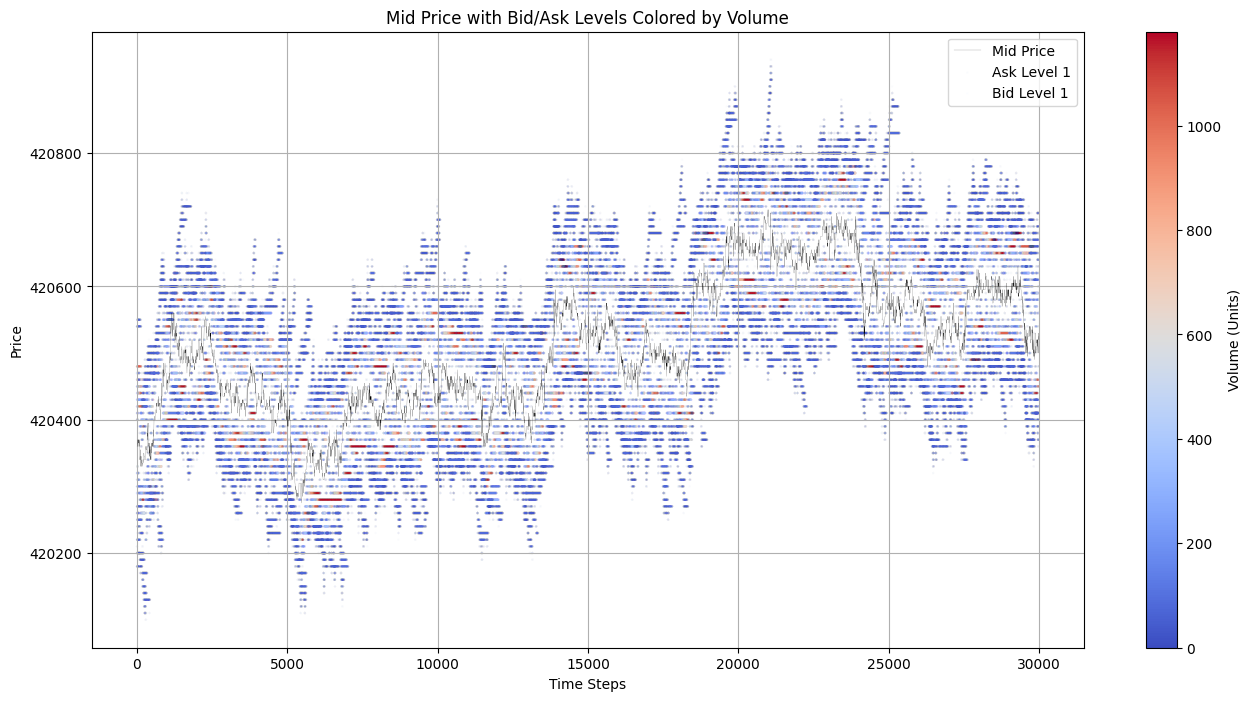

Probabilities OrderType: {} {1: 0.43, 2: 0.15, 3: 0.17, 4: 0.25}
Mean OrderPrice Diff Normal: {} 6
Standard Dev OrderPrice Diff Normal: {} 2


In [7]:
print('Deeper view into a orderbook snippet at the beginning of the Data')
plot_mid_price_with_volume_levels(LOBData[1000:31000])
print('Probabilities OrderType: {}', params["TypeDict"])
print('Mean OrderPrice Diff Normal: {}', params["mean"])
print('Standard Dev OrderPrice Diff Normal: {}', params["std"])
